# ROSSMANN KAGGLE COMPETITION

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

## Assignment
The task is to forecast the "Sales" column for the test set. **Note that some stores in the dataset were temporarily closed for refurbishment.**

## Data Fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load datasets
# using low_memory to avoid warning for dtype
df_train = pd.read_csv('data/train.csv', parse_dates=['Date'], low_memory=False)
df_test = pd.read_csv('data/test.csv', parse_dates=['Date'], low_memory=False)
df_store = pd.read_csv('data/store.csv', low_memory=False)

In [3]:
print("-------- TRAIN DATA TYPES --------")
print(df_train.dtypes)
print("-------- STORE DATA TYPES --------")
print(df_store.dtypes)
print("-------- TRAIN DATA SHAPE --------")
print("number of rows {0}, number of columns {1}".format(df_train.shape[0], df_train.shape[1]))
print("-------- TEST DATA SHAPE --------")
print("number of rows {0}, number of columns {1}".format(df_test.shape[0], df_test.shape[1]))
print("-------- STORE DATA SHAPE --------")
print("number of rows {0}, number of columns {1}".format(df_store.shape[0], df_store.shape[1]))

-------- TRAIN DATA TYPES --------
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object
-------- STORE DATA TYPES --------
Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object
-------- TRAIN DATA SHAPE --------
number of rows 1017209, number of columns 9
-------- TEST DATA SHAPE --------
number of rows 41088, number of columns 8
-------- STORE DATA SHAPE --------
number of rows 1115, number of columns 10


In [4]:
# checking the first rows of the dataset
df_train.head(), df_store.head(), print("unique stores: %d" % len(df_store.Store.unique()))

unique stores: 1115


(   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
 0      1          5 2015-07-31   5263        555     1      1            0   
 1      2          5 2015-07-31   6064        625     1      1            0   
 2      3          5 2015-07-31   8314        821     1      1            0   
 3      4          5 2015-07-31  13995       1498     1      1            0   
 4      5          5 2015-07-31   4822        559     1      1            0   
 
    SchoolHoliday  
 0              1  
 1              1  
 2              1  
 3              1  
 4              1  ,
    Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
 0      1         c          a               1270.0                        9.0   
 1      2         a          a                570.0                       11.0   
 2      3         a          a              14130.0                       12.0   
 3      4         c          c                620.0                        

In [5]:
# simple statistics on store file
df_store.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Store,1115,NaN,NaN,NaN,558,322.017,1,279.5,558,836.5,1115
StoreType,1115,4,a,602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Assortment,1115,3,a,593,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CompetitionDistance,1112,NaN,NaN,NaN,5404.9,7663.17,20,717.5,2325,6882.5,75860
CompetitionOpenSinceMonth,761,NaN,NaN,NaN,7.2247,3.21235,1,4,8,10,12
CompetitionOpenSinceYear,761,NaN,NaN,NaN,2008.67,6.19598,1900,2006,2010,2013,2015
Promo2,1115,NaN,NaN,NaN,0.512108,0.500078,0,0,1,1,1
Promo2SinceWeek,571,NaN,NaN,NaN,23.5954,14.142,1,13,22,37,50
Promo2SinceYear,571,NaN,NaN,NaN,2011.76,1.67494,2009,2011,2012,2013,2015
PromoInterval,571,3,"Jan,Apr,Jul,Oct",335,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Findings are the following:

1. for training we have a total of **1017209** with 9 columns. One of these columns is our target, which in this case is the Sales. For our testing case, I will be making predictions over **41088** records.

2. In our store file, there are 1115 rows, one for each store. I can also see frequecy levels on store type and assortment for a, promo interval for **Jan,Apr,Jul,Oct**, lots of NaN or Null values for some columns around **30~50%**.

3. Also I need to work on the data types for columns that should be caterogical and are displayed as either float or integers such as store, competition open since month, year, week, etc.

4. The store datafile will be merged into the training dataset and then used to generate mre features based on these columns. I will also handle missing values prior feeding the data to a machine learning pipeline.

In [6]:
# merge entire train and test dataset with store
df_train = pd.merge(df_train, df_store)
df_test = pd.merge(df_test, df_store)
print("-------- TRAIN DATA SHAPE --------")
print("number of rows {0}, number of columns {1}".format(df_train.shape[0], df_train.shape[1]))
print("-------- TRAIN DATA TYPES --------")
print(df_train.dtypes)

-------- TRAIN DATA SHAPE --------
number of rows 1017209, number of columns 18
-------- TRAIN DATA TYPES --------
Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object


In [7]:
# let's look at the missing values per column, and their percentages also
print("-------- MISSING DATA PERCENTAGES/SUM --------")
print(df_train.isnull().sum()/df_train.Store.size * 100)
print(df_train.isnull().sum())

-------- MISSING DATA PERCENTAGES/SUM --------
Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
dtype: float64
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo               

As stated before we have columns with nearly 50% of missing values, which we will need to treat correctly prior processing data. This can possible be affected by the fact that some stores remain closed during a period of time, but we will need to dig into details to gain better insights.


For our analysis we will first focus on understanding the nature and how the columns interact with the target value and after moved towards creating our pipeline for feature engineering and training/testing.

In [8]:
# let's look into the customers per stores and the top stores with more customers first
res = df_train.groupby('Store', as_index=False)['Customers'].sum().rename(columns={'Customers': 'Sum Customers per Store'})
print(res.sort_values('Sum Customers per Store', ascending=[0]).head(10))
print(res.sort_values('Sum Customers per Store', ascending=[0]).tail(10))
res = df_train.groupby('Store', as_index=False)['Customers'].max().rename(columns={'Customers': 'Max Customers per Store'})
print(res.sort_values('Max Customers per Store', ascending=[0]).head(10))
print(res.sort_values('Max Customers per Store', ascending=[0]).tail(10))
#
# minimum can be 0 so let's not compute this due stores can be closed
#
#res = df_train.groupby('Store', as_index=False)['Customers'].min().rename(columns={'Customers': 'Min Customers per Store'})
#print(res.sort_values('Min Customers per Store', ascending=[0]).head(10))
#print(res.sort_values('Min Customers per Store', ascending=[0]).tail(10))
res = df_train.groupby('Store', as_index=False)['Customers'].mean().rename(columns={'Customers': 'Avg Customers per Store'})
print(res.sort_values('Avg Customers per Store', ascending=[0]).head(10))
print(res.sort_values('Avg Customers per Store', ascending=[0]).tail(10))

      Store  Sum Customers per Store
732     733                  3206058
261     262                  3204694
561     562                  2924960
768     769                  2902351
1113   1114                  2509542
816     817                  2454370
1096   1097                  2280508
334     335                  2246936
258     259                  2210980
250     251                  1908934
      Store  Sum Customers per Store
1093   1094                   232530
709     710                   232122
1055   1056                   230408
262     263                   221342
878     879                   216037
701     702                   215970
572     573                   208622
253     254                   201507
406     407                   195715
542     543                   187583
      Store  Max Customers per Store
816     817                     7388
261     262                     5494
1113   1114                     4911
585     586                     4762
7

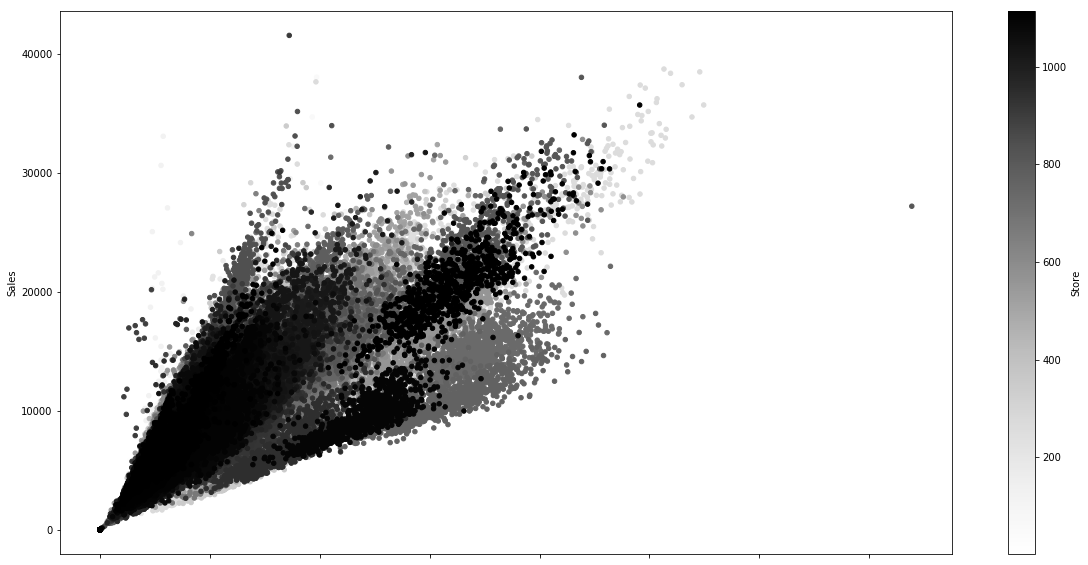

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
#let's look at the relation in between the number of customers and the store sales
df_train.plot.scatter(x='Customers',
                      y='Sales',
                      c='Store',
                      figsize=(20,10)
                     )

I can see high linear correlation in between the number of customers and the store sales, which is a good indicator for our machine learning model, there are points that are out of the "standard", where we could potentially call them outliers, but it would be making an assumption without having details (could be stores on christmas time, special events, etc).

Let's move into the open or close of stores and how this is setup in the dataset

In [10]:
# open or close stores
print("stores open percantage on dataset {0}\nstores close percentage on dataset {1}\nduring time period {2} - {3}".format((df_train['Open'].describe()['mean']*100),
                                                                                                                          100-(df_train['Open'].describe()['mean']*100),
                                                                                                                         df_train['Date'].min(),
                                                                                                                         df_train['Date'].max()))

stores open percantage on dataset 83.01066939045958
stores close percentage on dataset 16.989330609540417
during time period 2013-01-01 00:00:00 - 2015-07-31 00:00:00


**Note that some stores in the dataset were temporarily closed for refurbishment.**

The previous headline in the description of the dataset can give us a hint that we need to be careful when choosing to either include or not stores that were closed for refurbishment. We could potentially create a binary variable that meet criteria to if the store was closed due refurbishment or not.

First lets look at the **17%** of the stores that were closed and why they were closed.

In [11]:
print(df_train[df_train['Open'] == 0].groupby(['StateHoliday']).size())
print(df_train[(df_train['Open'] == 0) & (df_train['SchoolHoliday'] == 1)].groupby(['StateHoliday']).size())
print(df_train[(df_train['Open'] == 0) & (df_train['SchoolHoliday'] == 0)].groupby(['StateHoliday']).size())
print(df_train[(df_train['Open'] == 0) & (df_train['SchoolHoliday'] == 0)].groupby(['StateHoliday']).size()/df_train[df_train['Open'] == 0].groupby(['StateHoliday']).size())

StateHoliday
0    142677
a     19566
b      6545
c      4029
dtype: int64
StateHoliday
0    3067
a    5101
b    6067
c    4029
dtype: int64
StateHoliday
0    139610
a     14465
b       478
dtype: int64
StateHoliday
0    0.978504
a    0.739293
b    0.073033
c         NaN
dtype: float64


out of the 17% of the times stores were closed, **97%** it was due refurbishment, **139610** times throughout 2013-01-01 - 2015-07-31. As claimed at the beggining, the fact that they are closed and don't produce any sales and the reason is not affected by other variable (holidays), I don't find a clear pattern on if these times should be considered into the machine learning process, they might just add noise (sales = 0).

It is important that we remove these records prior training our regression.

As we know stores closed do not produce any sales, we can programatically apply zero to our testing set without the need of ML (only hard rules), we can train our model only on the records that produce profit to reduce bias.

In [12]:
df_train = df_train.drop(df_train[(df_train.Open == 0) & (df_train.Sales == 0)].index)
df_train = df_train.reset_index(drop=True)
df_train.shape

(844392, 18)

In [13]:
df_train[df_train['Open'] == 1]['Sales'].describe()

count    844392.000000
mean       6955.514291
std        3104.214680
min           0.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

I can still see that there are days that stores are open but their sales are zeros. These might be eitehr corrupt data or driven by specific events such as problems, activities, accidents, etc... I will check if these records make any significant contribution to the dataset or if they are just corrupted based on the amount of these records. After I will make the decision if either keep them into the training set or remove

In [14]:
print("There are only {0} stores that were opened but had 0 Sales".format(df_train[(df_train.Open == 1) & (df_train.Sales == 0)]['Store'].size))
print("Only {0} of them had Customers, these are the number of customers: {1}".format(len([i for i in df_train[(df_train.Open == 1) & (df_train.Sales == 0)]['Customers'] if i != 0]), [i for i in df_train[(df_train.Open == 1) & (df_train.Sales == 0)]['Customers'] if i != 0]))

There are only 54 stores that were opened but had 0 Sales
Only 2 of them had Customers, these are the number of customers: [5, 3]


As printed above, it is better to remove them from our training dataset as I considered them corrupted points due their very low frequency and potentially they dont correspond to potential recurrent events that our model should use to provide predictions on Sales.

In [15]:
df_train = df_train.drop(df_train[(df_train.Open == 1) & (df_train.Sales == 0)].index)
df_train = df_train.reset_index(drop=True)
df_train.shape

(844338, 18)

In [16]:
df_train.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

Now I will focus on analyzing how promotions can affect sales. This way I can make asumptions on if it makes sense (for a store point of view) to run promotions often, and from a ML point of view, how much this variable can affect our regression model afterwards.

In [17]:
print("stores in dataset are in promo the {}% of the time".format((df_train['Promo'].describe()['mean'])*100))

stores in dataset are in promo the 44.63556064040704% of the time


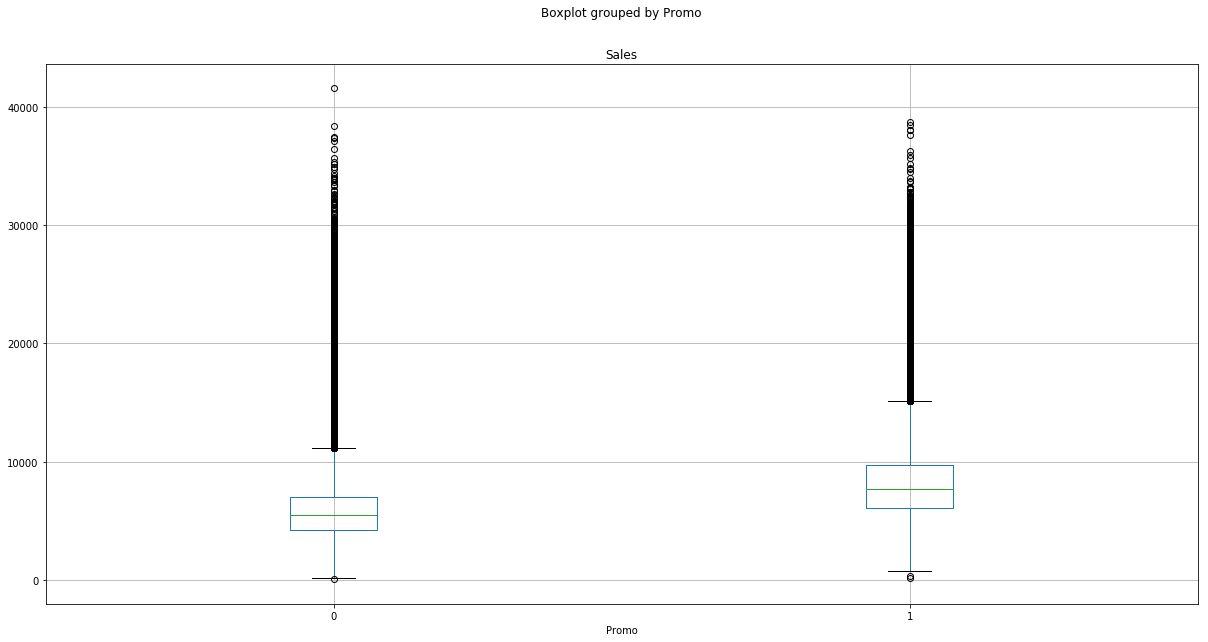

In [18]:
df_train.boxplot(column=['Sales'], by='Promo', figsize=(20,10))

As seen in the boxplot, data is well distributed over the two types (promotion or not) and this variable does make a difference in sales, although group 4 and 1 for stores with promotion have more variations on sales than when no promotion it is reasonable to think that this might be related to either the promotion is good enough for their clients or not so they spend more or less, producing different levels of profit (Sales).

Lastly we can see the distribution of data over the days of the week for stores and see if we can build features that would make a good representation for the sales behaviour, for example if more sales are made on the last day of the week rather than the first day, we could potentially create "is_first_day" or "is_last_day" as binary variables.

6    17.060940
2    17.049452
3    16.808671
5    16.419135
1    16.291698
4    15.944562
7     0.425540
Name: DayOfWeek, dtype: float64


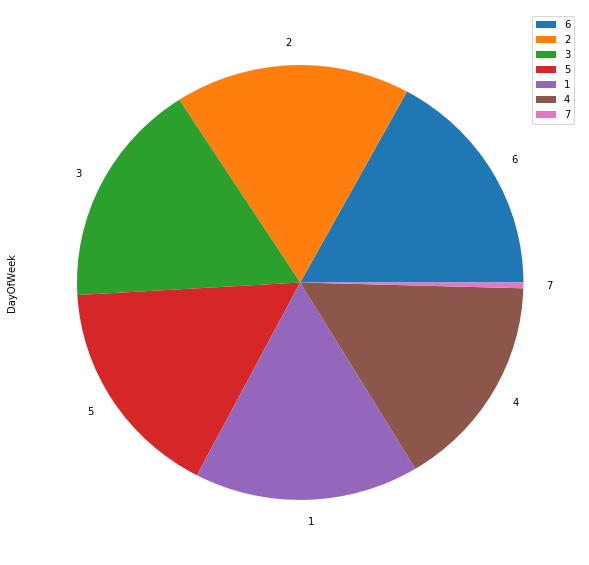

In [19]:
# distribution of records by day of the week on percentages
pd.DataFrame((df_train['DayOfWeek'].value_counts()/df_train['DayOfWeek'].size)*100).plot.pie(y='DayOfWeek', figsize=(10,10))
print((df_train['DayOfWeek'].value_counts()/df_train['DayOfWeek'].size)*100)

In [20]:
# behaviour of Sales by days of the week $ wise
df_train['Sales'].groupby(df_train['DayOfWeek']).describe()

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,137557.0,8216.252259,3691.609734,133.0,5538.0,7539.0,10133.0,41551.0
2,143955.0,7088.409086,3065.959513,866.0,4960.0,6502.0,8521.0,34692.0
3,141922.0,6728.786679,2781.109588,760.0,4829.0,6210.0,7987.0,33151.0
4,134626.0,6768.214973,2763.625181,520.0,4900.0,6246.0,7987.0,38367.0
5,138633.0,7073.034133,2764.528736,775.0,5205.0,6581.0,8324.0,38722.0
6,144052.0,5875.084935,2852.537857,46.0,3925.0,5425.0,7232.0,31683.0
7,3593.0,8224.723908,6235.152960,286.0,3314.0,6876.0,11418.0,37376.0


-------- RAW SALES --------
DayOfWeek
1    1130203012
2    1020411930
3     954962863
4     911177709
5     980555941
6     846317735
7      29551433
Name: Sales, dtype: int64
-------- PERCENTAGE OF SALES BY DAYOFWEEK --------
DayOfWeek
1    19.243457
2    17.374094
3    16.259722
4    15.514212
5    16.695484
6    14.409871
7     0.503159
Name: Sales, dtype: float64


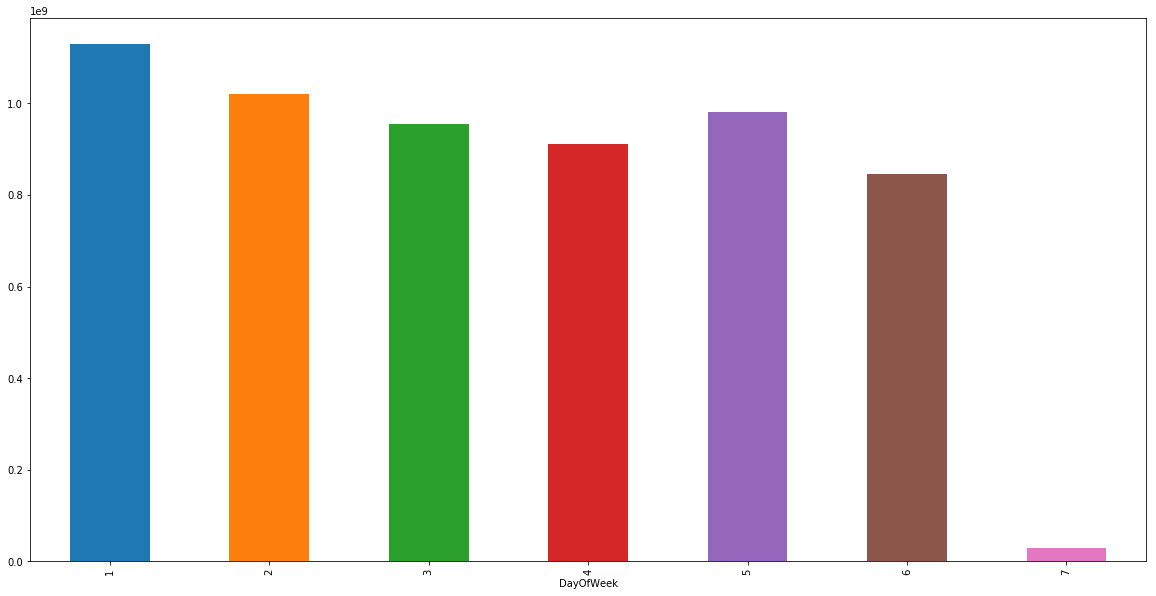

In [21]:
df_train['Sales'].groupby(df_train['DayOfWeek']).sum().plot(kind='bar', figsize=(20,10))
print("-------- RAW SALES --------")
print(df_train['Sales'].groupby(df_train['DayOfWeek']).sum())
print("-------- PERCENTAGE OF SALES BY DAYOFWEEK --------")
print((df_train['Sales'].groupby(df_train['DayOfWeek']).sum()/df_train['Sales'].sum())*100)

Slightly more profit on days 1 (monday), the profit is distributed evenly throughout the week except on Sundays. This makes sense also as the majority of stores are closed on sundays so it reduce the amount of records into the training dataset (**0.425540%** records with profit on sundays). Although the sum is not at the level of others days, **that the mean of sunday is nearly the same as the mean of monday**, this might be related to some special or specific event or celebration. This makes sense also becuase normally on sundays stores don't make much profit (looking at data) and only in specific occasions high profit happens, we can see this directly related due the **higher standard deviation**.

This is not an outlier though, we want to keep this in place so our model learns about these events.

I will now focus on the analysis directly on the store data and cleanup training dataset based on this analysis.

- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [22]:
# store analysis
# simple statistics on store file
print("-------- MISSING DATA PERCENTAGES/SUM --------")
print(df_store.isnull().sum()/df_store.Store.size * 100)
df_store.CompetitionDistance.describe()

-------- MISSING DATA PERCENTAGES/SUM --------
Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64


count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

very small percentage (0.27%) of the file doesn't contain information on compentition distance, as we know logically the distance in between store and competitors can't be zero and so I can't replace nulls with zero. Besides, This might mean either two things:
    1. no competitors on the area for that store.
    2. missing data points.

As there are only 3 stores with missing distance and due the maximum is way higher than the 75% percentil, I will use the median to avoid adding big gaps in the distribution. If I do so (last option), I will need to store these values to then replace for the same value for the store into the testing set (and possible new data points for predictions).
**2325.0**

In [23]:
df_store.CompetitionDistance.median()
df_train['CompetitionDistance'].fillna(df_store.CompetitionDistance.median(), inplace = True)
df_store['CompetitionDistance'].fillna(df_store.CompetitionDistance.median(), inplace = True)

### CompetitionOpenSince
Now I will analyze how to fill out the null values on these two columns based on the following statements:
    1. gives the approximate year and month of the time the nearest competitor was opened
I need to see if this variable has any meaning for the sales so I will analyzie the interaction of this variable with the target (sales).

In [24]:
print(df_train['Sales'].groupby(df_train['CompetitionOpenSinceMonth']).sum())
print(df_train['Sales'].groupby(df_train['CompetitionOpenSinceYear']).sum())

CompetitionOpenSinceMonth
1.0      76866134
2.0     205712761
3.0     382464261
4.0     498195718
5.0     247705034
6.0     288810663
7.0     333171030
8.0     225882753
9.0     648372829
10.0    315525218
11.0    463013705
12.0    325419565
Name: Sales, dtype: int64
CompetitionOpenSinceYear
1900.0      5222211
1961.0      6086195
1990.0     27862226
1994.0     11280525
1995.0     10472100
1998.0      5737921
1999.0     41892450
2000.0     60175681
2001.0     78278080
2002.0    136190565
2003.0     97218299
2004.0    103469923
2005.0    320132499
2006.0    247721540
2007.0    238392636
2008.0    271344522
2009.0    293110384
2010.0    288653207
2011.0    279859156
2012.0    424676043
2013.0    489038371
2014.0    380853414
2015.0    193471723
Name: Sales, dtype: int64


In [25]:
df_train['Sales'].groupby(df_train['CompetitionOpenSinceMonth']).describe()

,count,mean,std,min,25%,50%,75%,max
CompetitionOpenSinceMonth,,,,,,,,
1.0,10297.0,7464.905701,3612.144547,1095.0,4770.00,6720.0,9287.0,25737.0
2.0,31359.0,6559.927325,2889.624687,612.0,4465.00,6022.0,8085.0,32368.0
3.0,52680.0,7260.141629,3509.112514,582.0,5090.00,6549.5,8470.0,38025.0
4.0,72253.0,6895.156160,2965.591438,591.0,4831.00,6487.0,8457.0,37646.0
5.0,32858.0,7538.652200,4029.555969,715.0,4796.25,6526.0,9080.0,38722.0
6.0,37756.0,7649.397791,3194.427194,133.0,5444.00,7109.0,9285.0,38037.0
7.0,49008.0,6798.298849,2784.326025,297.0,4864.00,6226.0,8125.0,31448.0
8.0,29961.0,7539.226094,3431.249403,695.0,5200.00,7003.0,9314.0,32221.0
9.0,95467.0,6791.591115,2811.740753,530.0,4851.50,6286.0,8186.0,31269.0


In [26]:
df_train['Sales'].groupby(df_train['CompetitionOpenSinceYear']).describe()

,count,mean,std,min,25%,50%,75%,max
CompetitionOpenSinceYear,,,,,,,,
1900.0,622.0,8395.837621,2236.923301,4264.0,6784.75,8201.0,9696.25,15022.0
1961.0,779.0,7812.830552,2031.910432,4014.0,6298.00,7395.0,8889.00,17817.0
1990.0,3885.0,7171.744144,2309.314103,1675.0,5485.00,6878.0,8475.00,20738.0
1994.0,1552.0,7268.379510,2435.017234,3077.0,5312.00,6899.0,8948.75,16309.0
1995.0,1404.0,7458.760684,1998.797934,3516.0,5859.75,7167.5,8705.25,16339.0
1998.0,766.0,7490.758486,2053.471439,3771.0,5935.25,7206.0,8929.25,16930.0
1999.0,6213.0,6742.708836,4182.630211,685.0,3639.00,5493.0,8309.00,22137.0
2000.0,7631.0,7885.687459,2965.586220,902.0,5805.00,7339.0,9638.50,25506.0
2001.0,12157.0,6438.930657,3209.948613,1280.0,4320.00,5671.0,7613.00,30903.0


Based on the variaty of opening (stores and months) I will do the following to handle this missing datapoints:
    1. calculate the median of sales
    2. look for the closest median value on month and year
    3. replace month and year based on this value for missing records

In [27]:
print("median of sales: {0}".format(df_train.Sales.median()))
res = pd.DataFrame(df_train[['Sales', 'CompetitionOpenSinceYear']].groupby('CompetitionOpenSinceYear', as_index=False).median())
print(res.iloc[(res['Sales']-df_train.Sales.median()).abs().argsort()[:1]])
res = pd.DataFrame(df_train[['Sales', 'CompetitionOpenSinceMonth']].groupby('CompetitionOpenSinceMonth', as_index=False).median())
print(res.iloc[(res['Sales']-df_train.Sales.median()).abs().argsort()][:1])

median of sales: 6369.0
    CompetitionOpenSinceYear   Sales
17                    2010.0  6390.0
   CompetitionOpenSinceMonth   Sales
8                        9.0  6286.0


Using this then I will replace the value for missing data with ***CompetitionOpenSinceYear = 2010 and CompetitionOpenSinceMonth = 9**.

In [28]:
df_train['CompetitionOpenSinceYear'].fillna(2010.0, inplace=True)    # I will store it as float for now to not mess with existing data format.
df_train['CompetitionOpenSinceMonth'].fillna(9.0, inplace=True)    # same as above, I will change to categorical at last.
df_store['CompetitionOpenSinceYear'].fillna(2010.0, inplace=True)
df_store['CompetitionOpenSinceMonth'].fillna(9.0, inplace=True)

In [29]:
print("-------- MISSING DATA PERCENTAGES/SUM --------")
print(df_store.isnull().sum()/df_store.Store.size * 100)

-------- MISSING DATA PERCENTAGES/SUM --------
Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth     0.000000
CompetitionOpenSinceYear      0.000000
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64


#### Promo2Since
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

now I will fill out the three last variables. let's look into them first

In [30]:
print(df_store[['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].head())
print(df_store[['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].tail())
print(1-df_store['Promo2'].mean())


   Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0       0              NaN              NaN              NaN
1       1             13.0           2010.0  Jan,Apr,Jul,Oct
2       1             14.0           2011.0  Jan,Apr,Jul,Oct
3       0              NaN              NaN              NaN
4       0              NaN              NaN              NaN
      Promo2  Promo2SinceWeek  Promo2SinceYear     PromoInterval
1110       1             31.0           2013.0   Jan,Apr,Jul,Oct
1111       0              NaN              NaN               NaN
1112       0              NaN              NaN               NaN
1113       0              NaN              NaN               NaN
1114       1             22.0           2012.0  Mar,Jun,Sept,Dec
0.48789237668161434


In [31]:
print(df_store['Promo2SinceWeek'].unique().tolist())
print(df_store['Promo2SinceYear'].unique().tolist())

[nan, 13.0, 14.0, 1.0, 45.0, 40.0, 26.0, 22.0, 5.0, 6.0, 10.0, 31.0, 37.0, 9.0, 39.0, 27.0, 18.0, 35.0, 23.0, 48.0, 36.0, 50.0, 44.0, 49.0, 28.0]
[nan, 2010.0, 2011.0, 2012.0, 2009.0, 2014.0, 2015.0, 2013.0]


As seen above, these values are consistently missing due **48.79%** these stores are not running a continuing and consecutive promotion (Promo2). As these variables, even though they can be represented as categorical, they represent continues values and it makes sense to for example calculate the distance in between the opening of a store and if it's running since then or another timeline...

Based on that logic, we can replace these with 0, as it would actually mean that has been running since week and year 0, meaning "never".

In [32]:
df_store['Promo2SinceWeek'].fillna(0.0, inplace=True)
df_store['Promo2SinceYear'].fillna(0.0, inplace=True)
df_train['Promo2SinceWeek'].fillna(0.0, inplace=True)
df_train['Promo2SinceYear'].fillna(0.0, inplace=True)
df_store['Promo2SinceWeek'] = df_store['Promo2SinceWeek'].astype(int)
df_store['Promo2SinceYear'] = df_store['Promo2SinceYear'].astype(int)
df_train['Promo2SinceWeek'] = df_train['Promo2SinceWeek'].astype(int)
df_train['Promo2SinceYear'] = df_train['Promo2SinceYear'].astype(int)

In [34]:
print("-------- MISSING DATA PERCENTAGES/SUM --------")
print(df_store.isnull().sum()/df_store.Store.size * 100)

-------- MISSING DATA PERCENTAGES/SUM --------
Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth     0.000000
CompetitionOpenSinceYear      0.000000
Promo2                        0.000000
Promo2SinceWeek               0.000000
Promo2SinceYear               0.000000
PromoInterval                48.789238
dtype: float64


I'm only missing to handle the promotion intervarl, how this variable is related to the previous modifications I will do the same by filing the nulls with 0 and transforming into categorical type

In [36]:
df_store['PromoInterval'].fillna(0, inplace=True)
df_store['PromoInterval'] = df_store['PromoInterval'].astype(str)
df_train['PromoInterval'].fillna(0, inplace=True)
df_train['PromoInterval'] = df_train['PromoInterval'].astype(str)

In [38]:
print("-------- MISSING DATA PERCENTAGES/SUM --------")
print(df_train.isnull().sum()/df_train.Store.size * 100)

-------- MISSING DATA PERCENTAGES/SUM --------
Store                        0.0
DayOfWeek                    0.0
Date                         0.0
Sales                        0.0
Customers                    0.0
Open                         0.0
Promo                        0.0
StateHoliday                 0.0
SchoolHoliday                0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64


# Feature Engineering and ML Preparation
Now that i have no missing data and cleaned up our training set, I will build the set of features to train the model. I will focus first on changing the data types to the right format. then i will extract features from categorical variables (OHE possible), parsing dates to create new feats and select the right algorithm for the regression task.

In [40]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0,0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0,0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0,0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0,0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0,0,0


In [47]:
# variables Store, DayOfWeek should be converted to string (categoricals)
# variables CompetitionOpenSinceMonth, CompetitionOpenSinceYear should be converted to integer and then to string (categoricals)
# variables Promo2SinceWeek, Promo2SinceYear shoud be converted to string (categoricals)
df_train[['Store', 'DayOfWeek', 'Promo2SinceWeek', 'Promo2SinceYear']] = df_train[['Store', 'DayOfWeek', 'Promo2SinceWeek', 'Promo2SinceYear']].astype(str)
df_train[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']] = df_train[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].astype(int).astype(str)
print(df_train.dtypes)

Store                                object
DayOfWeek                            object
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth            object
CompetitionOpenSinceYear             object
Promo2                                int64
Promo2SinceWeek                      object
Promo2SinceYear                      object
PromoInterval                        object
dtype: object


In [48]:
df_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,0,0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9,2008,0,0,0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9,2008,0,0,0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9,2008,0,0,0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9,2008,0,0,0,0
5,1,6,2015-07-25,4364,500,1,0,0,0,c,a,1270.0,9,2008,0,0,0,0
6,1,5,2015-07-24,3706,459,1,0,0,0,c,a,1270.0,9,2008,0,0,0,0
7,1,4,2015-07-23,3769,503,1,0,0,0,c,a,1270.0,9,2008,0,0,0,0
8,1,3,2015-07-22,3464,463,1,0,0,0,c,a,1270.0,9,2008,0,0,0,0
9,1,2,2015-07-21,3558,469,1,0,0,0,c,a,1270.0,9,2008,0,0,0,0
